## European Soccer Database
### Dataset Source: https://www.kaggle.com/hugomathien/soccer

Insights are very important in every sport, and football being the most popular sport around the globe is highly focused around team's performance. Football is a very complex game, requiring a large array of individual skills, and also chemistry.

In this dataset we have access to more than 25.000 matches, 10.000 players, 11 European countries with their championship, teams and attributes sourced from EA Sports Fifa (attributes which inclues weekly updates based on real life player's performance) and betting odds from up to 10 different providers.

The most interesting and difficult task, is obviously to predict the outcome of a game.
The bookies use 3 classes (Home Win, Draw, Away Win). The precision of the odds is usually around 53% of the time.
Football is a very unpredictible game. The baseline would be around 46% precision, based just on the fact that home teams are most likely to win.

Is is widely known that EA Sports Fifa attributes are determined by a large team of football experts which are full time working on updating player's live form. Even though it is a fairly limited analysis, we try to determine how relevant the skill stat analysis is.

We will cluster the players to see if we can determine their field position just by looking at their stats, and also we will try to see which players can cover multiple positions but running with different parameters. We will also cluster hierahically to see how their positions are related (e.g. a left back would be related to a center back or a left wing, but no way related to a striker).

The data is available as a 300 MB SQLite database. We will first define our columns (player attributes) that we are going to investigate and we will run basic SQL queries to retrieve the data and convert it into dataframes.

In [270]:
library(ggplot2)
library(RSQLite)
library(plyr)
library(dplyr, warn.conflicts = FALSE)

db <- dbConnect(SQLite(),"~/Downloads/soccer/database.sqlite")
Country <- dbGetQuery(db,"Select * from Country")
Match <- dbGetQuery(db,"Select * from Match")
League <- dbGetQuery(db,"Select * from League")
Team <- dbGetQuery(db,"Select * from Team")

skill_stats <- c(
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'free_kick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'balance',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
    'aggression',
    'interceptions',
    'positioning',
    'vision',
    'penalties',
    'marking',
    'standing_tackle',
    'sliding_tackle',
    'gk_diving',
    'gk_handling',
    'gk_kicking',
    'gk_positioning',
    'gk_reflexes'
)

attributes <- c(
    'player_name',
    'date',
    'Player.player_fifa_api_id',
    'Player.player_api_id',
    'preferred_foot',
    'attacking_work_rate',
    'defensive_work_rate',
    skill_stats
)

cols <- paste(attributes, collapse=",")
# join player data with attributes
Player <- dbGetQuery(db, sprintf("SELECT %s FROM Player JOIN Player_Attributes ON Player.player_api_id = Player_Attributes.player_api_id", cols))

home_match <- count(Match,home_team_api_id)
away_match <- count(Match,away_team_api_id)

names(home_match)[names(home_match)=="n"] <- "home_matches_number"
names(away_match)[names(away_match)=="n"] <- "away_matches_number"

head(Player)

player_name,date,player_fifa_api_id,player_api_id,preferred_foot,attacking_work_rate,defensive_work_rate,overall_rating,crossing,finishing,⋯,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
Aaron Appindangoye,2016-02-18 00:00:00,218353,505942,right,medium,medium,67,49,44,⋯,54,48,65,69,69,6,11,10,8,8
Aaron Appindangoye,2015-11-19 00:00:00,218353,505942,right,medium,medium,67,49,44,⋯,54,48,65,69,69,6,11,10,8,8
Aaron Appindangoye,2015-09-21 00:00:00,218353,505942,right,medium,medium,62,49,44,⋯,54,48,65,66,69,6,11,10,8,8
Aaron Appindangoye,2015-03-20 00:00:00,218353,505942,right,medium,medium,61,48,43,⋯,53,47,62,63,66,5,10,9,7,7
Aaron Appindangoye,2007-02-22 00:00:00,218353,505942,right,medium,medium,61,48,43,⋯,53,47,62,63,66,5,10,9,7,7
Aaron Cresswell,2016-04-21 00:00:00,189615,155782,left,high,medium,74,80,53,⋯,66,59,76,75,78,14,7,9,9,12


For the first task we want to group the teams by their individual national championship. We are interested in listing the top 10-15 teams over the last years, by checking first the wins percentage, and also the points average (1 per draw, 0 per lose, 3 for win).

In [271]:
new_match_data <- cbind(home_match, away_match)

new_match_data <- new_match_data %>% mutate(
    total_matches = home_matches_number + away_matches_number,
    wins = 0,
    win_percentage = 0,
    points = 0,
    points_average = 0,
    country = "",
    team_name = ""
)

for(rowIdx in rownames(new_match_data))
{
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(rowIdx)])
    new_match_data$country[as.numeric(rowIdx)] <- Country$name[Country$id==Match$country_id[as.numeric(home_indexes[1])]]
    new_match_data$team_name[as.numeric(rowIdx)] <- Team$team_long_name[Team$team_api_id==new_match_data$home_team_api_id[as.numeric(rowIdx)]]
}

drops_columns <- c("home_matches_number","away_matches_number")
new_match_data <- new_match_data[ , !(names(new_match_data) %in% drops_columns)]

for(id in rownames(new_match_data)) {
    # win_count stores the number of wins if the current team has scored more goals than the opponent team.
    win_count <- 0
    points <- 0
    #Find all the records in main "Match" table which match the current team id
    home_indexes <- which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(id)])
    away_indexes <- which(Match$away_team_api_id == new_match_data$away_team_api_id[as.numeric(id)])
    
    for(i in home_indexes)
    {
        if(Match$home_team_goal[i] > Match$away_team_goal[i])
        {
            win_count <- win_count +1
            points <- points + 3
        }
        
        if (Match$home_team_goal[i] == Match$away_team_goal[i])
        {
            points <- points + 1
        }
    }
    
    for(i in away_indexes)
    {
        if (Match$away_team_goal[i] > Match$home_team_goal[i])
        {
            win_count <- win_count + 1
            points <- points + 3
        }
        
        if (Match$away_team_goal[i] == Match$home_team_goal[i])
        {
            points <- points + 1
        }
    }
    
    new_match_data$wins[as.numeric(id)] <- win_count
    new_match_data$points[as.numeric(id)] <- points
    new_match_data$win_percentage[as.numeric(id)] <- as.double(win_count/new_match_data$total_matches[as.numeric(id)]*100)
    new_match_data$points_average[as.numeric(id)] <- as.double(points/new_match_data$total_matches[as.numeric(id)])
}


drop_columns <- c("away_team_api_id")
new_match_data <- new_match_data[ , !names(new_match_data) %in% drop_columns]
names(new_match_data)[names(new_match_data)=="home_team_api_id"]<-"team_id"


sorted_teams_by_wins <- new_match_data[order(-new_match_data$win_percentage),]
sorted_teams_by_points <- new_match_data[order(-new_match_data$points_average),]

There is no surprise that football clubs with great tradition are filling the top spots. Barcelona and Real Madrid are on the top spots. Rangers, Celtic from Scotland and Benfica, Porto representing Portugal are near. Follow up we have Bayern Munich, long time champion of German league. A single team from England, Manchester United, and by that it is confirmed that the English Premier League is the toughest one to be consistent, it is reasonably the most balanced.

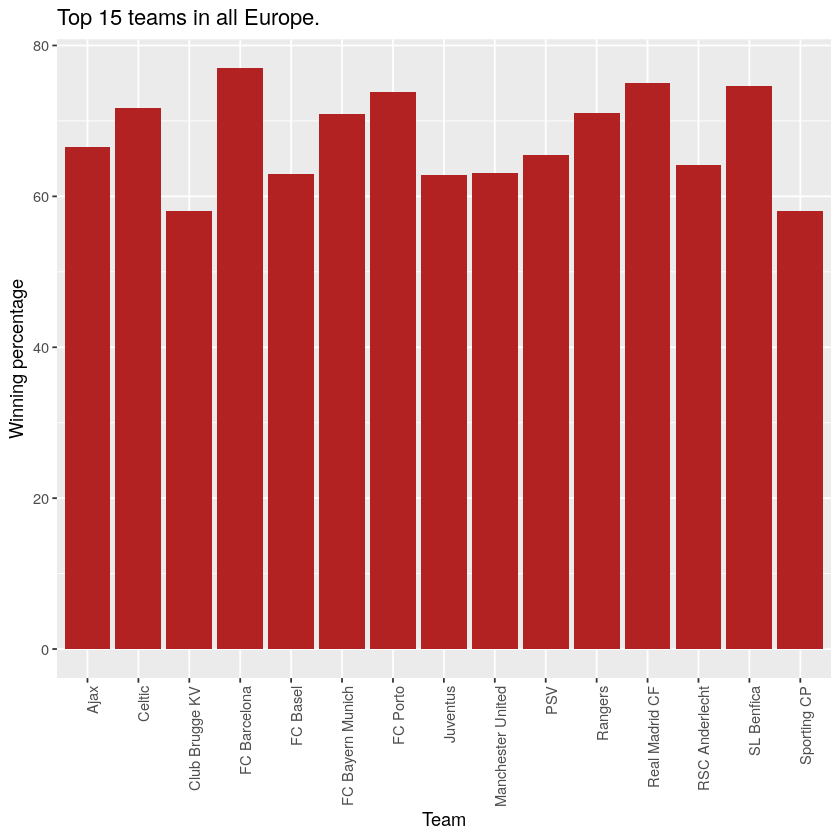

In [278]:
ggplot(data=sorted_teams_by_wins[0:15,], aes(x=team_name,y=win_percentage)) + 
geom_bar(stat="identity", fill="firebrick")+labs(x="Team",y="Winning percentage")+
ggtitle("Top 15 teams in all Europe.")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

Comparing by the average points per game, we see almost no difference, except coming on top Paris Saint Germain. France league it is highly contested by a number of several teams among those years. Besides Paris there are strong teams coming from Monaco, Marseilles, Lyon. As we can see below, Germany is dominated by Bayern, Scotland is dominated by far by the two teams: Celtic and Rangers. Portugal is also very imbalanced, Benfica and Sporting are the two big forces, Braga coming on top 3.

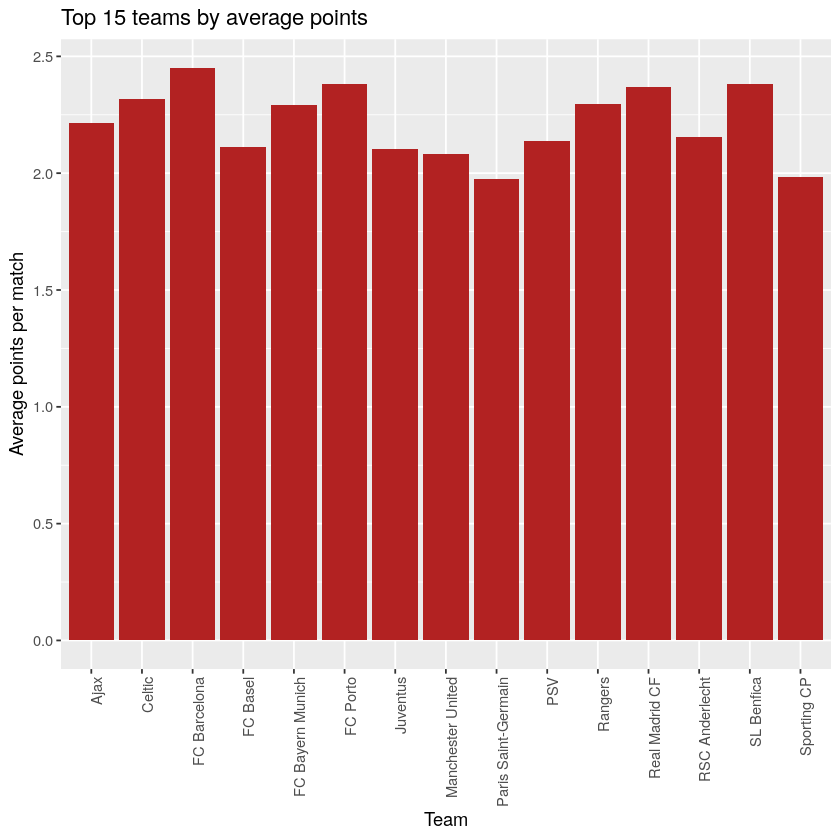

In [281]:
ggplot(data=sorted_teams_by_points[0:15,], aes(x=team_name,y=points_average)) + 
geom_bar(stat="identity", fill="firebrick")+labs(x="Team",y="Average points per match")+
ggtitle("Top 15 teams by average points")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

Now that we've seen the top teams in Europe, now we define a function to see top 10 in each championship.

In [23]:
plot_top_teams <- function(n, country) {
    league_team <- sorted_teams_by_points[sorted_teams_by_points$country==country,]
    league <- league_team[order(-league_team$points_average),][1:n,]
    ggplot(data=league,aes(x=team_name,y=points_average))+
    geom_bar(stat='identity',fill="firebrick ")+labs(x="Team",y="Average Points")+
    ggtitle(sprintf("Top %d Teams in %s League", n, country))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

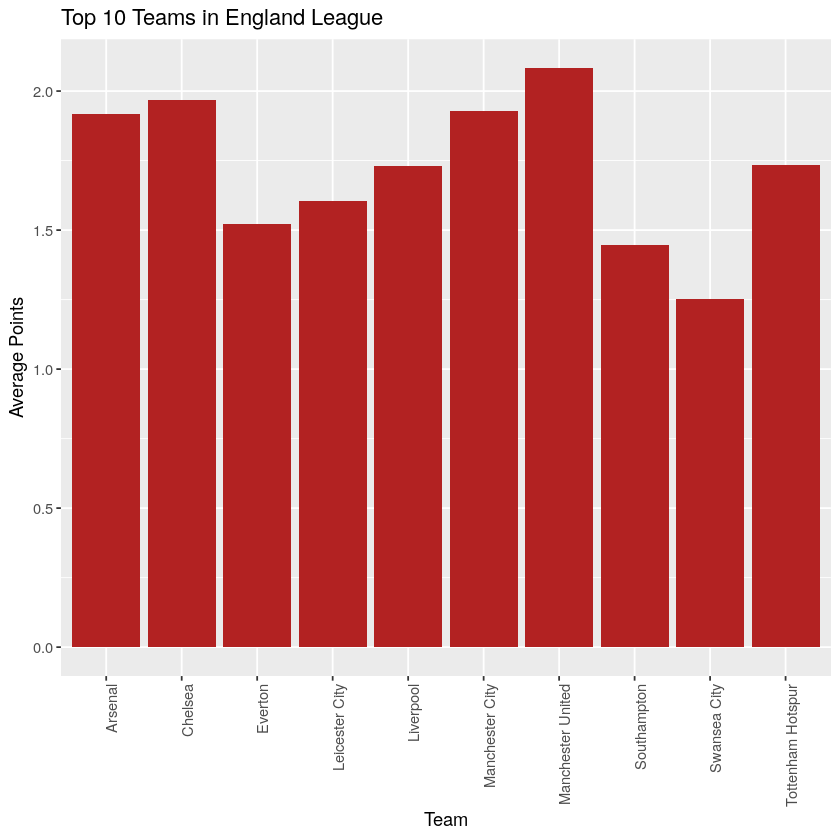

In [284]:
plot_top_teams(10, "England")

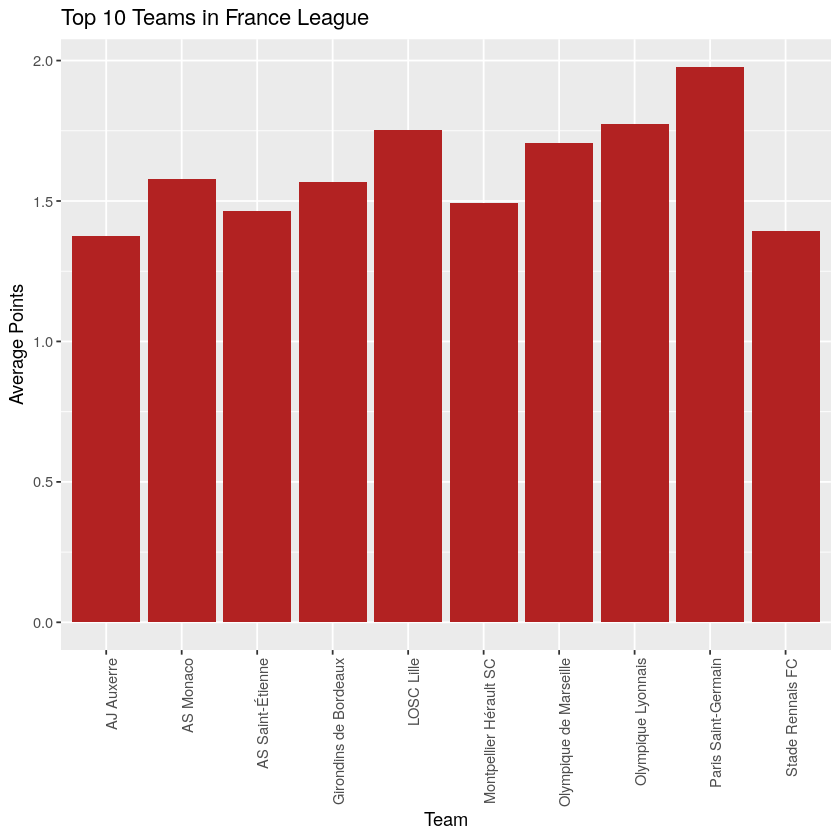

In [286]:
plot_top_teams(10, "France")

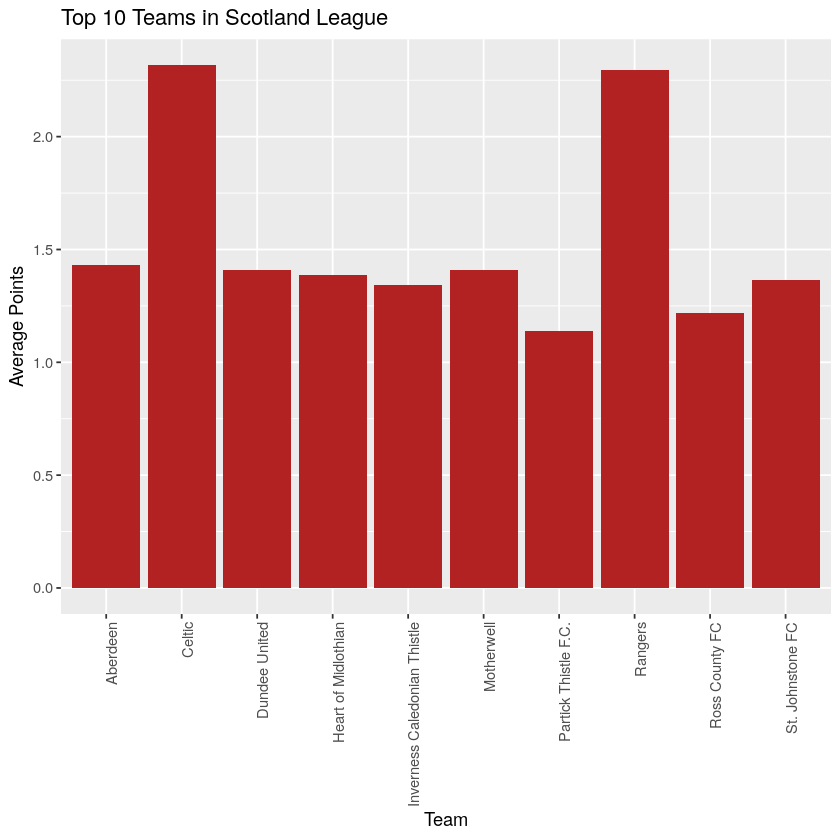

In [288]:
plot_top_teams(10, "Scotland")

Next, we will shift our focus on player's individual skill attributes.
First, we will calculate principal components and we will plot some interesting skills to compare among some of the strongest teams in Europe.

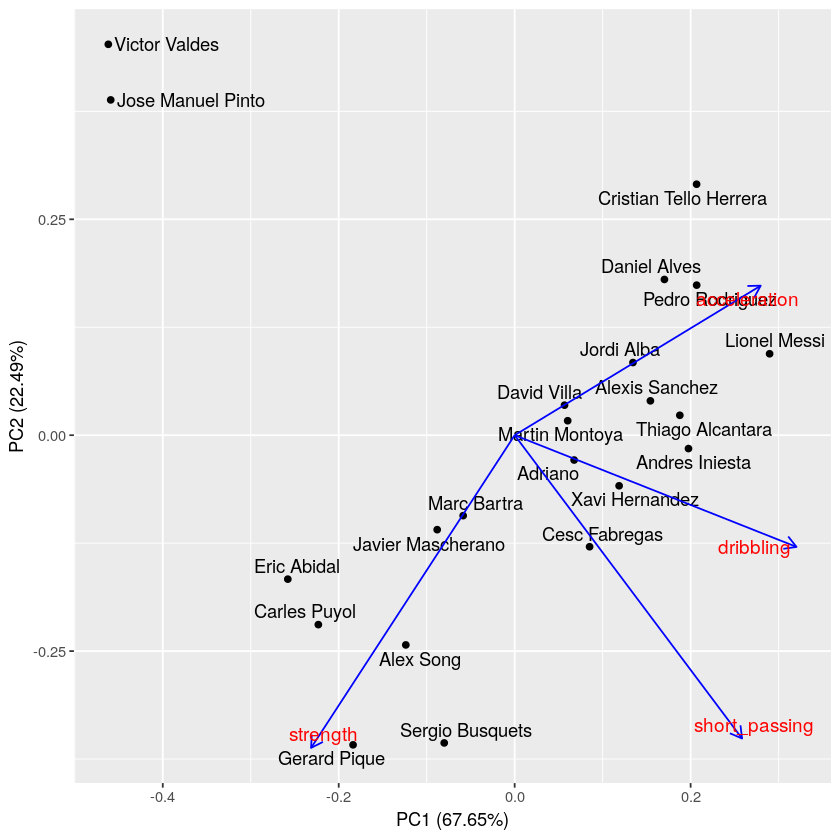

In [156]:
# get the player attributes closest to the date
get_player_attributes <- function(player_api_id, match_date = Sys.Date()) {
    versions <- Player[Player$player_api_id == player_api_id,]
    versions[order(abs(difftime(versions$date, match_date))),][1,]
}

get_team_players_by_name <- function(team_name) {
    query <- paste0("SELECT * FROM Team WHERE team_long_name LIKE '%", team_name, "%'")
    team_api_id <- dbGetQuery(db, query)$team_api_id
    home_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE home_team_api_id = %s", team_api_id))
    away_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE away_team_api_id = %s", team_api_id))

    # remove fields with nulls
    home_team_matches <- na.omit(home_team_matches)
    away_team_matches <- na.omit(away_team_matches)

    all_players <- list()
    for (i in 1:11) {
        home_players <- as.list(home_team_matches[sprintf("home_player_%d", i)])
        away_players <- as.list(away_team_matches[sprintf("away_player_%d", i)])
        all_players <- append(unlist(all_players), unlist(home_players))
        all_players <- append(unlist(all_players), unlist(away_players))
    }
    all_players <- unique(all_players)
    # construct the dataframe
    team_df <- do.call(rbind, Map(function(x) data.frame(get_player_attributes(x)), x=all_players))
    # use player's name instead of numeric index
    rownames(team_df) <- team_df$player_name
    team_df
}
                                  
plot_pca_for_team <- function(team_name, attributes) {
    players_df <- get_team_players_by_name(team_name)
    pca <- prcomp(players_df[,attributes], center = TRUE,scale. = TRUE)
    library(ggrepel)  
    library(ggfortify)
    autoplot(pca, label = TRUE, label.repel = T, loadings = TRUE, loadings.colour = 'blue', loadings.label = TRUE, 
         loadings.label.size = 4, loading.label.color = 'red',loadings.label.repel=TRUE) 
}
plot_pca_for_team("Barcelona", c("acceleration", "short_passing", "strength", "dribbling"))

We take for example FC Barcelona. It is the most creative team in terms of passing and chance creation. We can see that goalkeepers and defendind players are very far, strength being very important. Barcelona is famously known as a team with the average height and weight very low for attacking players.
As for short passing we see Xavi Hernandez and Cesc Fabregras, two very famous players which standout in this regard.
For dribbling and acceleration we have Lionel Messi up front, and players like Thiago or Iniesta shortly behind.

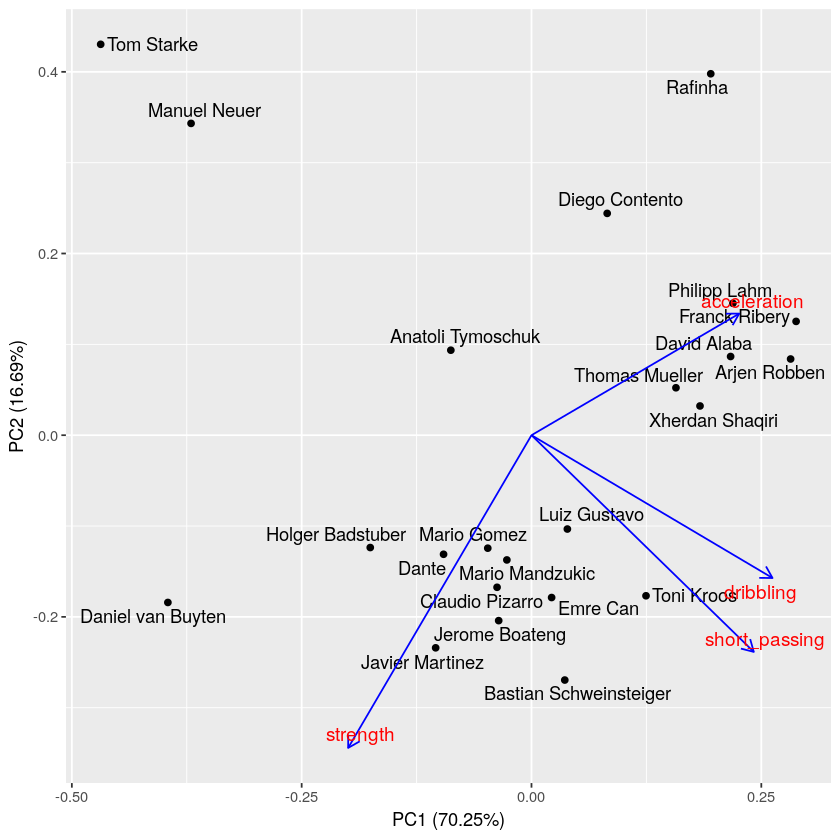

In [290]:
plot_pca_for_team("Bayern", c("acceleration", "short_passing", "strength", "dribbling"))

In the German or Italian team, it is widely known that players must have stronger physical. In this regard, let's take Bayern. Strength is common for both defenders, midfielders and attackers. The only players which lack strength are the ones who have great acceleration and they play on the sides. The German football is more pragmatic and we see that there are no players who stand out in both dribbling and short passing.

In this dataset we dont' have the actual field position. We will try to cluster the players using K-Means algorithm. First, we want to find out the optimal number of clusters, and for doing that we will use the elbow tehnique.

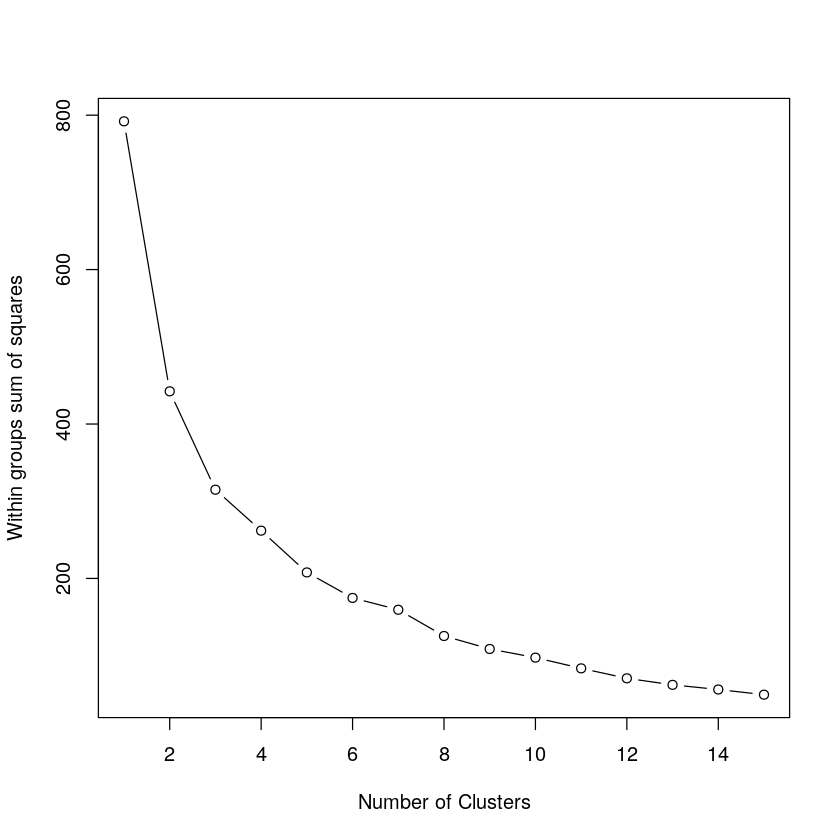

In [292]:
wss <- (nrow(players.df) - 1) * sum(apply(players.df,2,var))
for (i in 2:15) wss[i] <- sum(kmeans(players.df,
   centers=i)$withinss)
plot(1:15, wss, type="b", xlab="Number of Clusters",
  ylab="Within groups sum of squares")

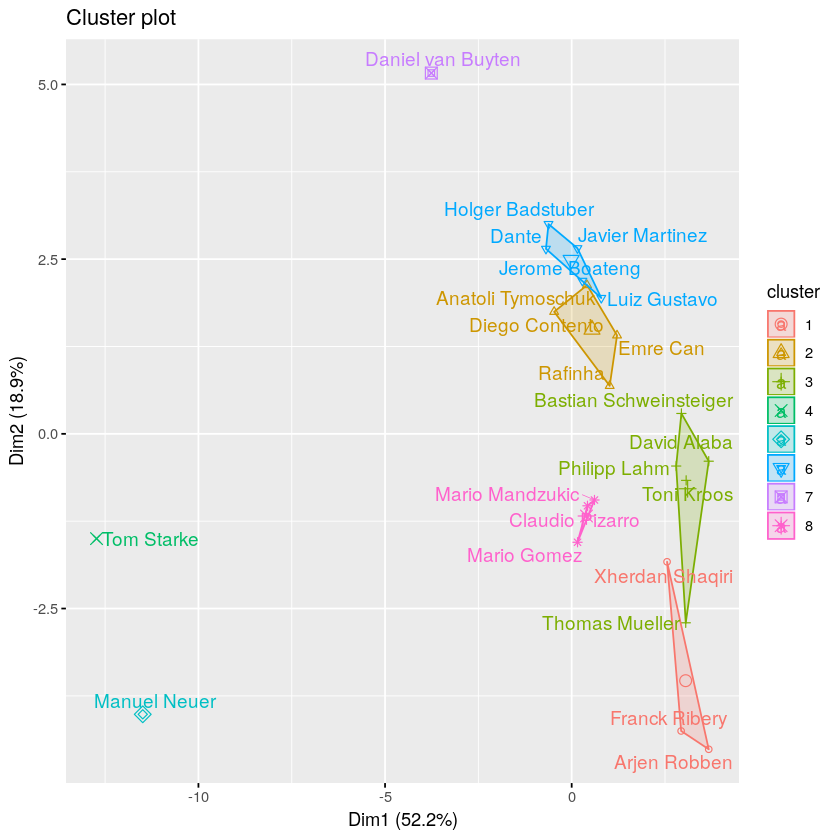

In [294]:
plot_clusters_for_team <- function(team_name, centers=8) {
    library(cluster)    # clustering algorithm
    library(factoextra) # visualization
    players_df <- get_team_players_by_name(team_name)
    players_df[skill_stats] <- scale(players_df[skill_stats])
    k5 <- kmeans(players_df[skill_stats], centers=centers, nstart = 25)
    fviz_cluster(k5, data = players_df, choose.vars=skill_stats, repel=TRUE) # prevent text overlapping
}

plot_h_clusters_for_team <- function(team_name) {
    players_df <- get_team_players_by_name(team_name)
    clusters <- hclust(dist(players_df[skill_stats]))
    plot(clusters,, main="Field positions hierarchy by skill stats")
}

plot_clusters_for_team("Bayern", 8)

As we can see, the algorithm predicted correctly Tom Starke and Manuel Neuer as goalkeepers. The biggest surpise here is into the defender cluster. All of them were central backs except Luiz Gustavo. At the time Luiz  Gustavo played at Bayern he was playing as midfielder. After a couple of years, in 2016 he was transfered at Merseilles and began playing as a center back. Apparently, we was fit for this role for quite a long time. Into the same category we have Emre Can, a player which fills different roles. At that time he was in the same category with right and left backs, but he now plays as central midfielder, being close to Gustavo and Schweinsteiger. Another great view is Philipp Lahm, right back, very close to Toni Kroos. When Guardiola came as manager and introduced Lahm as central midfielder everyone was at shock. Apparently the skills do match relatively in the squad. The wings and strikers come very clear. Mandzuic, Pizarro, Gomez being strong, slow, but a huge aerial threat. Mueller is somewhere between striker and wing and central midfield, which is exactly the roles he can play.
Daniel van Buyten by the time of the dataset record was near retirement, he is a very slow but aggresive defender. He is closest to the center backs but his physical form decreased by the time, all other players are much younger.

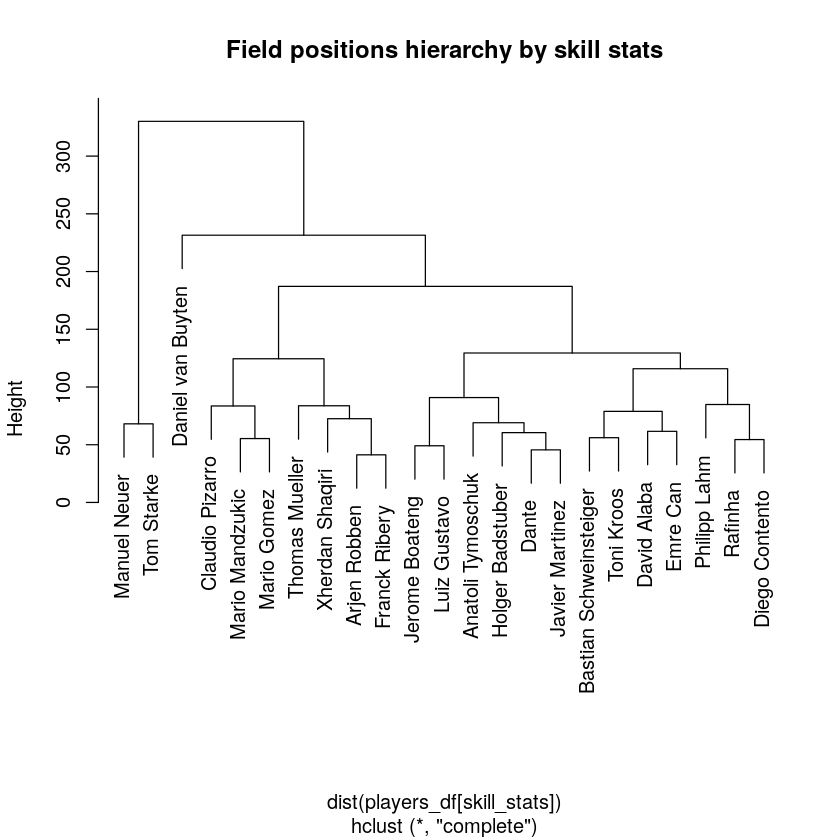

In [30]:
plot_h_clusters_for_team("Bayern")

We have an even better view on hierarchical clustering. The two goalkeepers are separated again. Gomez and Mandzukic are tall strikers, Pizarro is a not as tall as them. Robben and Ribery are a legendary duo on the wings, and Shaqiri and Mueller can fit as well. Boateng and Gustavo are players which played back then different positions but their phisionomy is similar. The strange coincidence is that Boateng - Gustavo, Alaba - Can are pairs which have origins outside of Europe.

A very popular curiosity comes from the prefered foot of the most talented players. Even though there are examples of both sides, the most creative ones like Messi, Maradona, Zidane. On the box plot we see no big difference in terms of average rating.

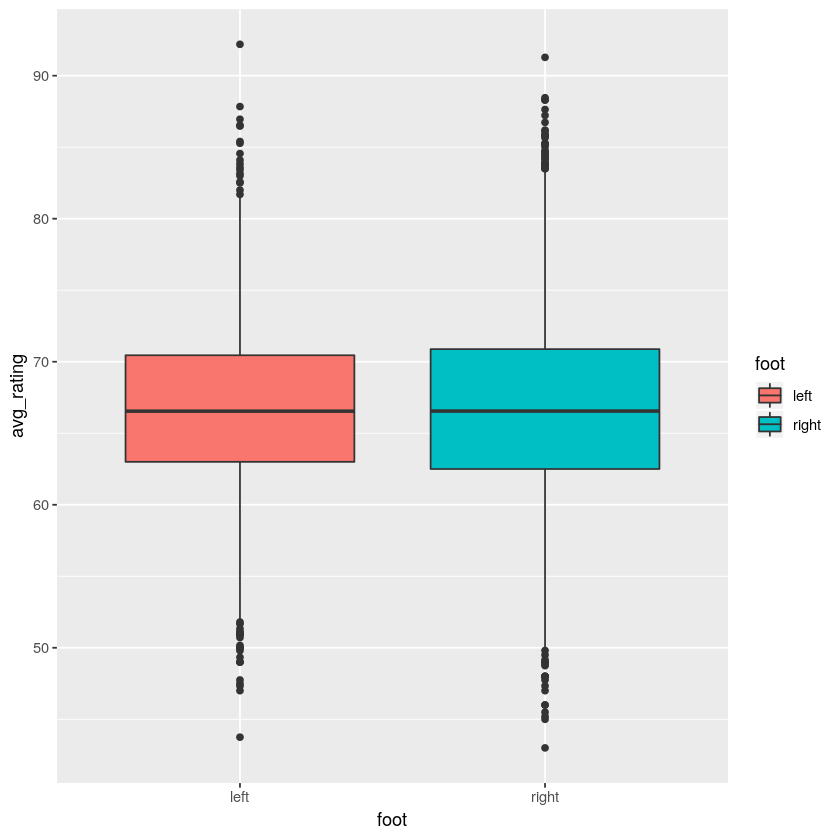

In [295]:
comparison <- Player %>%
  select(player_name, overall_rating, preferred_foot) %>%
  group_by(player_name) %>%
  summarise(avg_rating = mean(overall_rating), foot = names(which.max(table(preferred_foot))))

comparisonDF <- as.data.frame(comparison)


idx <- which(is.na(comparisonDF$avg_rating))
comparisonDF <- comparisonDF[-idx,]


ggplot(comparisonDF, aes(fill = foot)) + 
    geom_boxplot(aes(x = foot, y = avg_rating))


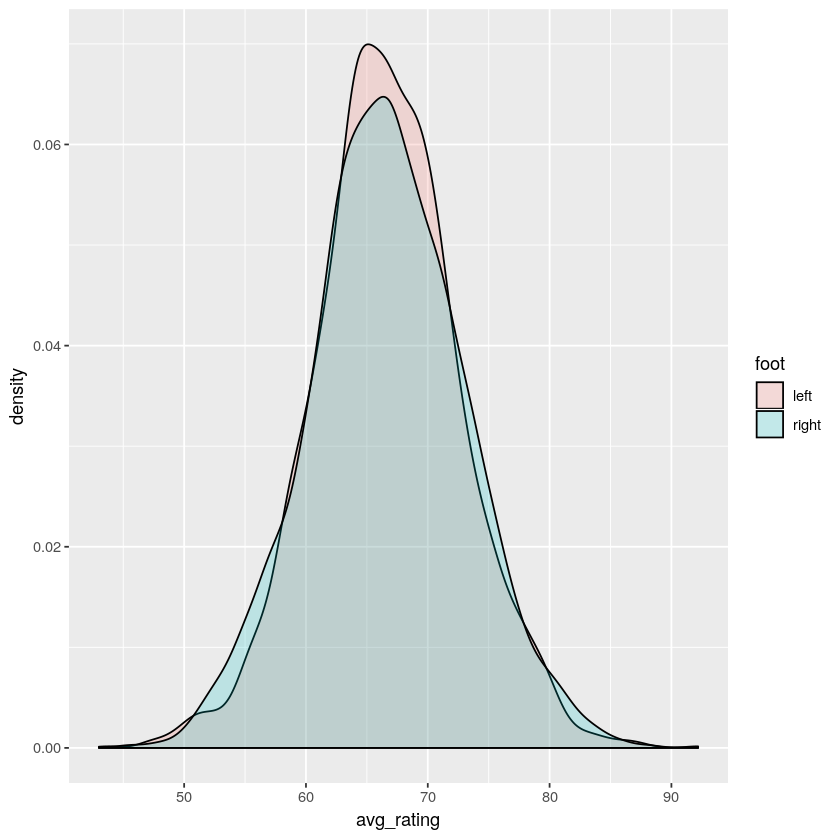

In [296]:
ggplot(comparisonDF, aes(x = avg_rating, fill = foot)) + 
    geom_density(alpha = 0.2)

The distributions are very similar, and by performing the KS test we can see that there is no strong statistical effect between the average rating of a player and his prefered foot.

In [302]:
lefties <- comparison %>%
  filter(foot == "left") %>%
  arrange(desc(avg_rating))

righties <- comparison %>%
  filter(foot == "right") %>%
  arrange(desc(avg_rating))

ks.test(lefties$avg_rating, righties$avg_rating)

Warning message in ks.test(lefties$avg_rating, righties$avg_rating):
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  lefties$avg_rating and righties$avg_rating
D = 0.029074, p-value = 0.08731
alternative hypothesis: two-sided


The most interesting question would be to be able to predict the outcome of a match based on the lineups.
After generating a SQL query on the large number of columns, we see that there are no rows in the database which includes information about the player's completly.

In [299]:
matches <- na.omit(data.frame(Match))

select.rows <- c()
join.rows <- c()

for (i in 1:11) {
    for (place in c('home', 'away')) {
        for (skill in skill_stats) {
            col <- sprintf('%splayer%s.%s', place, i, skill)
            alias <- sprintf('%s_player_%s_%s', place, i, skill)
            col <- sprintf('%s AS %s', col, alias)
            select.rows <- c(select.rows, col) 
        }        
        alias <- sprintf('%splayer%s', place, i)
        player <- sprintf('%s_player_%s', place, i)
        join.row <- sprintf('LEFT JOIN Player_Attributes %s  ON %s = %s.player_fifa_api_id ', alias, player, alias)
        join.rows <- c(join.rows, join.row)
    }
}

select.section <- paste(select.rows, collapse = ', ')
join.section <- paste(join.rows, collapse = ' ')
sql.query <- sprintf('SELECT %s FROM MATCH %s LIMIT 100', select.section, join.section)
MatchWithStats <- dbGetQuery(db, sql.query)

In order to make a good use of our data available, we can use the existing odds provided by different bookies and we could predict the goal difference. An odd close to one would mean a clear victory and an odd above 5 would mean that it is expected to loose by a large margin.
We have a regression model based on SVM and we can see that the RMSE is aprox. 1.56, on the test data (20% of whole).

In [310]:
library(caret)

matches <- na.omit(data.frame(Match))

betting.cols <- colnames(matches)[toupper(colnames(matches)) == colnames(matches)]
matches$goals.diff <- matches$home_team_goal - matches$away_team_goal
# matches$outcome <- ifelse(goals.diff == 0, 'D', ifelse(goals.diff > 0, 'W', 'L'))
matches <- matches[c(betting.cols, 'goals.diff')]

test.train <- createDataPartition(y=matches$goals.diff,p=0.8,list=FALSE)
train <- matches[test.train,]
test <- matches[-test.train,]

head(train)

library(e1071)
model <- svm(train$goals.diff ~ ., data = train)

model
pred <- predict(model, test)
xtab <- table(pred, test$goals.diff)

rmse <- RMSE(pred,test$goals.diff)
rmse

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,⋯,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,goals.diff
3249,1.40,4.5,8.50,1.35,4.60,9.00,1.35,4.5,7.3,1.40,⋯,1.44,4.75,8.50,1.35,4.60,9.00,1.40,4.33,8.50,0
3251,1.80,3.6,4.50,1.80,3.50,4.40,1.80,3.4,4.0,1.80,⋯,1.83,3.75,4.75,1.80,3.50,4.40,1.83,3.50,4.33,5
3252,1.17,7.0,17.00,1.18,6.25,16.00,1.17,5.8,13.0,1.17,⋯,1.20,7.00,19.00,1.18,6.25,16.00,1.17,6.50,17.00,1
3253,2.50,3.4,2.75,2.60,3.30,2.75,2.40,3.2,2.7,2.60,⋯,2.62,3.40,2.75,2.60,3.30,2.75,2.50,3.40,2.70,1
3254,2.00,3.4,3.80,2.00,3.40,3.60,2.10,3.3,3.1,2.00,⋯,2.00,3.50,4.00,2.00,3.40,3.60,2.00,3.40,3.60,-5
3256,4.20,3.5,1.91,4.10,3.50,1.85,3.30,3.3,2.0,3.75,⋯,4.33,3.60,1.95,4.10,3.50,1.85,4.00,3.40,1.91,3



Call:
svm(formula = train$goals.diff ~ ., data = train)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.03333333 
    epsilon:  0.1 


Number of Support Vectors:  1201


[1] 1.544957

In [ ]:
svm_tune <- tune(svm, train.x=train, train.y=train$goals.diff, 
              kernel="radial", ranges=list(cost=10^(-1:2), gamma=c(.5,1,2)))

print(svm_tune)

In [ ]:
model <- svm(train$goals.diff ~ ., data = train,cost=10,  gamma=0.5)

model
pred <- predict(model, test)

rmse <- RMSE(pred,test$goals.diff)
rmse